# *Cifar10* Photo Classification#

This project is to build a nerual network to successfully classify *cifar10* photos into their correspond classes.

### What is *cifar10*?###
*cifar10* is a database of `32` * `32` pixels photos each pixel consist of `3` values of brightness(red, green, and blue). Each photo is an object from a class of `airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, and `truck`. Each class has exactly `1000` photos with a total of 10000 in the database

### What is the goal?###
The goal is to build a nerual network to classify each input photo into its object class as accurate as possible.

## Step 0: Library##

- Keras from TensorFlow

In [1]:
import numpy as np
from tensorflow import keras
import pandas as pd

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\Yulun\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Yulun\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Yulun\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


## Step 1: Read in the data##
The *cifar10* files are divided into five batchs of training and one batch of test for us to evaluate the performance of the model. Each of the batchs is pickled into packages so I have to unpickle them one by one in order for keras to read them.

In [2]:
def unpickle(file):
    """To unpickle the cifar10 file into readable np arrays"""
    import pickle
    with open(file, 'rb') as fo:
        dictionary = pickle.load(fo, encoding='latin1')
    return dictionary

# Set cifar10 files directory
cifar10_dir = 'C:/Users/Yulun/Documents/Projects/cifar-10-batches-py/cifar10_batches'

# Unpickle cifar10 files
metaDict = unpickle('C:/Users/Yulun/Documents/Projects/cifar-10-batches-py/cifar10_batches/batches.meta')

# Get the classes names
label_names = metaDict['label_names']

## Step 2: Data Split ##

This learning model follows a train, validate, test process, so I have to manuelly split the sets. Gather all data and decide the training set, validation set, and the test set. For labels of the input data, I have to manually seperate them from original data arrays in order for latter varification

There two additional things done to original data in order to improve the final performance of the model. 
1. For each values of brightness in the photo, I use a min-max scaler to increase the difference of brighness for different pixels.
2. Merge all training data into one set to generate a gradually increasing for accuracy. This helps to decide if the model is underfit or overfit.(for epochs size selecting use)


In [3]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Unpickle each batch of cifar10 files and return the features(32, 32, 3) and their labels
    """
    import pickle
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
	# As stated in the CIFAR-10/CIFAR-100 dataset, the row vector, (3072) represents an color image of 32x32 pixels.
	# In order to feed an image data into a CNN model, 
	# the dimension of the input tensor should be either (width x height x num_channel) or (num_channel x width x height).
	# I am going to use the first choice because the default choice in tensorflow’s CNN operation is so.
    features = batch['data'].reshape(len(batch['data']), 3, 32, 32).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return (features, labels)
 
def normalize(x):
    """
    Normalize the x's using max/min distance
    min in x's as a 0
    max in x's as a (max - min)
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x


# Load the x(features) and y(labels) for each batch
(x_training1, y_training1) = load_cfar10_batch(cifar10_dir, 1)
(x_training2, y_training2) = load_cfar10_batch(cifar10_dir, 2)
(x_training3, y_training3) = load_cfar10_batch(cifar10_dir, 3)
(x_training4, y_training4) = load_cfar10_batch(cifar10_dir, 4)

# Concatenate batch 1-4 as training set
x_training = np.concatenate([x_training1, x_training2, x_training3, x_training4])
y_training = np.concatenate([y_training1, y_training2, y_training3, y_training4])

# Using batch 5 as validation set(could be other batch, but should
# be 1/4 to 1/3 of the traing set size)
x_validate, y_validate = load_cfar10_batch(cifar10_dir, 5)

# Unpickle test batch since it is an individual batch
testDict = unpickle('C:/Users/Yulun/Documents/Projects/cifar-10-batches-py/cifar10_batches/test_batch')
x_test = testDict['data'].reshape(len(testDict['data']), 3, 32, 32).transpose(0, 2, 3, 1)
y_test = testDict['labels']	

# Normalize and one-hot encoding for training, validation, and test
x_training = normalize(x_training)
y_training = to_categorical(y_training)
x_validate = normalize(x_validate)
y_validate = to_categorical(y_validate)
x_test = normalize(x_test)
y_test = to_categorical(y_test)

## Step 3: Build Nerual Network##

#### Technique used:####
1. VGG blockes - Baseline model


> Each VGG block contains one or more concolutional layers and a pooling layer after that. With four VGG blocks in this case, max the marginal benefits of adding a VGG block. In other words, adding a 5th VGG block slows down the training process but do not significantly increase the model performance. Use this structure as the baseline model for this project.


2. BatchNormalization

> The BatchNormalization after a convolutional layer standardlized the values of each filtered image by making sure the mean of each sample is `0`. Adding this BatchNormalization layer both speed up the training and increase generality of the model.


3. Max pooling

> The max pooling layer after BatchNormalization layer shrink the original image by an area of `1/4`(in other words, `1/2` for width and height). This max pooling layer makes sure only important features are passed on to next layer and also decrease the image size, which helps while flatten the image at last.


3. Dropout with increasing rate

> Dropout layers randomly drop some nodes by given proportion. In this CNN model, the dropout rates are increasing as the model reaches to the end(`0.1` -> `0.2` -> `0.3` -> `0.4` -> `0.5`). The major reason of doing this is generalization. As nodes are passing to the end, more and more nodes will be dropped, which forces the model to make decisions using less and less inputs and put more attention at the begining or the model.



In [5]:
# Set constent
num_classes = len(label_names)  # The number of classes
input_shape = (32, 32, 3)       # The input shape 32 * 32 pixels, 3 RGB brightness for each pixel

# Construct a sequential model
model = Sequential()

# Starting add layers to the model
# First VGG blockes
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())     # BatchNormalization after convolutional layer
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())     # BatchNormalization after convolutional layer
model.add(MaxPooling2D((2, 2)))     # MaxPooling2D to keep important features as well as shirnk info size
model.add(Dropout(0.1))             # Drop some portion of nodes to increase generality of model

# Second VGG blockes
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Third VGG blockes
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Fourth VGG blockes
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

# Flat and dense layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Final softmax layer
model.add(Dense(num_classes, activation='softmax'))

# The optimizer gives the learning rate lr and some other parameters.
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Model complie
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Print the summary of this model
print(model.summary())

# Save the trained model for continues training
model.save('C:/Users/Yulun/Documents/Projects/cifar-10-batches-py/cifar10_batches/cifar10_classifier_1.h5', overwrite=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

## Step 4: Training##

- Data Augmentation: use ImageDataGenerators to generate new samples based on the given arguments. For example, flip the image, shift the image, and zoom the image. Both increase the original sample size and help model to learn common features in each class. The techniques include(all change apply randomly):

> 1. Horizontal flip
> 2. Vertical flip
> 3. Horizontal shift
> 4. Vertical shift
> 5. Zoom in/out*
> 6. Rotations*

> *Adding these features made the model spend much more time to train because it increase the generalization very much. As adding first few data augmentation features already pull training accuracy and validation accuracy line very close, these features was not included by default in this project.

In [4]:
# To pick up from where I left off
model = load_model('C:/Users/Yulun/Documents/Projects/cifar-10-batches-py/cifar10_batches/cifar10_classifier_1.h5')

# create data generator
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1)


#Train model
epochs = 100
history = model.fit(datagen.flow(x_training, y_training, batch_size=128),
                    batch_size=128,
                    epochs=epochs,
                    validation_data=(x_validate, y_validate),
                    verbose=1,
                    shuffle=True)

# Save the trained model for continues training
model.save('C:/Users/Yulun/Documents/Projects/cifar-10-batches-py/cifar10_batches/cifar10_classifier_1.h5', overwrite=True)

Epoch 1/100
 35/313 [==>...........................] - ETA: 52s - loss: 2.7762 - accuracy: 0.1440

KeyboardInterrupt: 

## Step 5: Training Analysis##
Plot the graph of accuracy change of both training set and validation set as epochs goes on.

With first 500 epochs of training, we can see there is no big gap between training and validation accuracy curve. And both of the accuracy is growing.

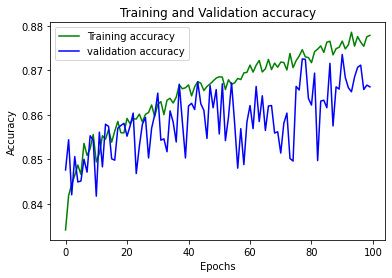

In [48]:
# Gather information of two groups
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']

# Generate lines for both group
plt.plot(range(0, epochs), loss_train, 'g', label='Training accuracy')
plt.plot(range(0, epochs), loss_val, 'b', label='validation accuracy')

# Manually set the y limit
#plt.ylim([0.5, 1])

# Setting the title and other words info
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Print
plt.show()

## Step 6: Performance##
Run the CNN model on final test set and evaluate. Test set should only run **ONCE** at the end of the project and no changes should be made to maximizing the perfomance on the test set. This is the real case simulation!

In [46]:
def get_class_from_softmax(softmax_list):
    """Get the index of the highest value in given softmax list"""
    max_value = 0.0     # Note the max probalility until present
    max_index = 0       # Note the max probability's index until present
    for i in range(len(softmax_list)):
        if softmax_list[i] > max_value:
            max_value = softmax_list[i]
            max_index = i
    return max_index    # return the max_index

# Load the model from directory because we saved the model after building and training
model = load_model('/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/cifar10_classifier_1.h5')

# Run model on test set
print(model.evaluate(x=x_test, y=y_test))

# Use two lists to note the pred vs. real
y_hat_label = list()
y_label = list()

# y_hat is the predicted value on test set x's, but only max_index
y_hat = model.predict(x_test)

# Convert max_index to class name and append that into there correspond list
for i in range(len(y_hat)):
    y_hat_label.append(label_names[get_class_from_softmax(y_hat[i])])
    y_label.append(label_names[get_class_from_softmax(y_test[i])])

# Generate a confusion matrix with index names
confusion_mtx = pd.DataFrame(
    confusion_matrix(y_hat_label, y_label, labels=label_names), 
    index=['pred:airplane', 'pred:automobile', 'pred:bird', 'pred:cat', 'pred:deer', 'pred:dog', 'pred:frog', 'pred:horse', 'pred:ship', 'pred:truck'], 
    columns=['true:airplane', 'true:automobile', 'true:bird', 'true:cat', 'true:deer', 'true:dog', 'true:frog', 'true:horse', 'true:ship', 'true:truck']
)

# Display confusion matrix and score report
display(confusion_mtx)
print('Classification Report')
print(classification_report(y_label, y_hat_label, target_names=label_names))

313/313 [==============================] - 1s 3ms/step - loss: 0.4484 - accuracy: 0.8599
[0.44843217730522156, 0.8598999977111816]


,true:airplane,true:automobile,true:bird,true:cat,true:deer,true:dog,true:frog,true:horse,true:ship,true:truck
pred:airplane,891,6,36,16,6,5,3,10,46,8
pred:automobile,13,957,0,4,1,3,1,1,19,43
pred:bird,20,0,792,53,30,24,11,10,4,3
pred:cat,5,1,19,657,20,91,12,10,2,1
pred:deer,6,1,30,39,824,27,6,24,4,0
pred:dog,2,0,27,95,9,764,3,10,1,1
pred:frog,7,1,70,102,69,45,960,8,7,6
pred:horse,12,1,19,18,39,38,3,926,4,0
pred:ship,23,4,5,6,1,1,1,0,898,8
pred:truck,21,29,2,10,1,2,0,1,15,930


Classification Report
              precision    recall  f1-score   support

    airplane       0.87      0.89      0.88      1000
  automobile       0.92      0.96      0.94      1000
        bird       0.84      0.79      0.81      1000
         cat       0.80      0.66      0.72      1000
        deer       0.86      0.82      0.84      1000
         dog       0.84      0.76      0.80      1000
        frog       0.75      0.96      0.84      1000
       horse       0.87      0.93      0.90      1000
        ship       0.95      0.90      0.92      1000
       truck       0.92      0.93      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

